In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

# Define the path to the dataset folder in Google Drive
dataset_path = '/content/drive/My Drive/Chest_Xray_Model/chest_xray'

# List the contents of the folder
try:
    print(os.listdir(dataset_path))
except FileNotFoundError:
    print(f"Error: Folder not found at {dataset_path}")

['chest_xray', 'val', 'test', 'train', '__MACOSX', 'val_fixed']


## Dataset Description

The dataset used for this project is the **Chest X-Ray Images (Pneumonia)** dataset.

*   **Source:** While the direct link is not provided in the code, this dataset is widely available and commonly used for educational purposes in medical imaging. A common source is Kaggle ([https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) - *Note: Please verify this is the exact source if possible*).

*   **Context:** The dataset contains chest X-ray images organized into three folders: `train`, `test`, and `val`. The images are categorized into two classes: 'NORMAL' and 'PNEUMONIA'. The images were collected from pediatric patients aged one to five years old at Guangzhou Women and Children's Medical Center, Guangzhou.

*   **Attributes:** The dataset consists of JPEG images. The original images have varying resolutions, but they are resized to 150x150 pixels during preprocessing in this notebook. The images are grayscale but are treated as 3-channel RGB during loading and processing due to the requirements of the pre-trained model.

*   **Size:** The dataset is split as follows:
    *   Training set: 5216 images
    *   Validation set: 16 images
    *   Test set: 624 images

*   **Class Distribution (inferred from generator output):**
    *   The dataset contains images belonging to 2 classes ('NORMAL' and 'PNEUMONIA').
    *   *Note: The exact distribution (number of images in each class) within the train, validation, and test splits is not explicitly shown in the current code's output but is important for understanding potential class imbalance. It is recommended to add code to print these counts.*

*   **Potential Limitations/Biases:** As with many medical datasets, potential limitations include the single source (Guangzhou Women and Children's Medical Center), which might introduce biases related to the specific patient population, equipment, or imaging protocols used. The original paper associated with the dataset mentions an imbalanced distribution between the classes, with a significantly higher number of pneumonia cases in the training set. This imbalance should be considered during model training and evaluation. The very small validation set size (16 images) is a significant limitation for reliably monitoring training progress and preventing overfitting.

In [8]:
import os

# Define the variable repo_path
repo_path = 'Chest-Xray-Pneumonia-Detection'

# Check if the repository folder already exists
if not os.path.exists(repo_path):
    print(f"Repository '{repo_path}' not found. Cloning...")
    # Clone the repository if it doesn't exist
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git
else:
    print(f"Repository '{repo_path}' already exists.")

Repository 'Chest-Xray-Pneumonia-Detection' not found. Cloning...
Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 287 (delta 27), reused 7 (delta 7), pack-reused 225 (from 2)
Receiving objects: 100% (287/287), 3.43 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [9]:
# Change the current working directory to the repository path
os.chdir(repo_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/Chest-Xray-Pneumonia-Detection


In [10]:
# Define the path to the dataset folder in Google Drive
dataset_path = '/content/drive/My Drive/Chest_Xray_Model/chest_xray/'

# Use the create_generators function from the imported preprocessing_2 module
try:
    from notebooks.preprocessing_2 import create_generators
    train_gen, val_gen, test_gen = create_generators(dataset_path)
    print("Data generators created successfully using custom preprocessing.")
except ImportError:
    print("Error: create_generators function not found in notebooks.preprocessing.")
except Exception as e:
    print(f"Error creating data generators: {e}")



from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("📊 Computed Class Weights:", class_weights)


Found 5216 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data generators created successfully using custom preprocessing.
📊 Computed Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [11]:
import sys
import os

# Get the current working directory (which should be the repo root)
repo_root = os.getcwd()

# Add the repository root to the Python path
sys.path.append(repo_root)

# Import the preprocessing module from within the notebooks directory
try:
    from notebooks import preprocessing_2
    print("Successfully imported preprocessing_2 module.")

except ImportError as e:
    print(f"Error importing preprocessing_2 module: {e}")
    print(f"Check if 'preprocessing_2.py' exists in '{os.path.join(repo_root, 'notebooks')}' and if the module/function names are correct.")

Successfully imported preprocessing_2 module.


In [12]:
import os

# Define the path to the notebooks directory within the cloned repository
notebooks_path = os.path.join(os.getcwd(), 'notebooks')

# Check if the directory exists and list its contents
if os.path.exists(notebooks_path) and os.path.isdir(notebooks_path):
    print(f"Contents of '{notebooks_path}':")
    print(os.listdir(notebooks_path))
else:
    print(f"Error: Directory not found at '{notebooks_path}'")

Contents of '/content/Chest-Xray-Pneumonia-Detection/notebooks':
['ResNet50.ipynb', 'VGG16.ipynb', 'CustomCNN.ipynb', 'preprocessing.py', '__pycache__', 'preprocessing_2.py']


## Load efficientnetb0

### Subtask:
Load the pre-trained EfficientNetB0 model from `tensorflow.keras.applications`, making sure to exclude the top classification layer.


## Model Application and Justification

### Choice of Base Model: EfficientNetB0

We chose EfficientNetB0 as the pre-trained base model for this image classification task. EfficientNet models are known for achieving high accuracy with fewer parameters and computations compared to other CNN architectures like ResNet or VGG, making them efficient for training and inference. EfficientNetB0 is the smallest model in the EfficientNet family, offering a good balance between performance and computational cost, which is suitable for this project. The model is pre-trained on the ImageNet dataset, allowing us to leverage learned features and benefit from transfer learning, which is particularly helpful for medical image datasets where data might be limited.

In [13]:
# 1. Import the EfficientNetB0 class from tensorflow.keras.applications.
from tensorflow.keras.applications import EfficientNetB0

# Define image dimensions - MUST match the target_size in your data generators (preprocessing_2.py)
img_width, img_height = 224, 224 # Updated to match preprocessing_2.py

# 2-5. Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet',
                            include_top=False,
                            input_shape=(img_height, img_width, 3)) # Ensure this is 224, 224, 3

# 6. Store the loaded model in a variable (already done in step 2-5)

# 7. Optionally, print base_model.summary()
base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

### Custom Top Layers

On top of the pre-trained EfficientNetB0 base model (excluding its original classification head), we added the following custom layers for binary classification:

1.  **`GlobalAveragePooling2D`**: This layer reduces the spatial dimensions of the feature maps from the base model by averaging the values of each feature map across its height and width. This helps to reduce the number of parameters and computational complexity while retaining important information.
2.  **`Dense (128 units, activation='relu')`**: A fully connected layer with 128 neurons and ReLU activation. This layer learns non-linear combinations of the features extracted by the base model and the pooling layer, preparing them for the final classification. The number of units (128) was chosen as a reasonable balance for capturing complexity without excessive parameters.
3.  **`Dropout (0.3)`**: A dropout layer with a rate of 0.3. This layer randomly sets 30% of the input units to 0 during training. This technique acts as a regularizer, helping to prevent overfitting by forcing the network to learn more robust features that are not overly dependent on specific neurons.
4.  **`Dense (1 unit, activation='sigmoid')`**: The final fully connected layer with a single neuron and a sigmoid activation function. For binary classification, the sigmoid activation outputs a value between 0 and 1, which can be interpreted as the probability of the input image belonging to the positive class ('PNEUMONIA' in this case).

These layers were added to adapt the pre-trained base model to our specific binary classification task and introduce appropriate regularization.

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf # Re-import tensorflow if not available in this cell

# 3. Define the input to the model.
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# 4. Pass the input through the pre-trained base_model.
x = base_model(inputs)

# 5. Add a GlobalAveragePooling2D layer.
x = GlobalAveragePooling2D()(x)

# 6. Add dense layers.
x = Dense(128, activation='relu')(x) # Example dense layer

# 7. Include a Dropout layer.
x = Dropout(0.3)(x) # Example dropout rate

# 8. Add a final Dense layer with sigmoid activation for binary classification.
outputs = Dense(1, activation='sigmoid')(x)

# 9. Create the final model.
model = Model(inputs=inputs, outputs=outputs)

# 10. Print the summary of the new model architecture.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


In [16]:
# ==============================================
# 4️⃣ TRAIN MODEL WITH CALLBACKS
# ==============================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Chest_Xray_Model/best_model.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [17]:
# Define the number of epochs
epochs = 10 # You can adjust the number of epochs based on experimentation

# Define the batch size (must match the batch_size used in the data generators)
batch_size = 32 # Batch size used in preprocessing_2.py

# Calculate steps per epoch and validation steps
# Ensure we don't have zero steps if dataset size is smaller than batch size, though unlikely here
steps_per_epoch = train_gen.samples // batch_size if train_gen.samples > 0 else 1
validation_steps = val_gen.samples // batch_size if val_gen.samples > 0 else 1

# Train the model using the train_generator with the fit() method. Use the val_generator for validation.
print(f"Starting training for {epochs} epochs...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Model training completed.")

Starting training for 10 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8832 - loss: 0.2517
Epoch 1: val_accuracy improved from -inf to 0.73958, saving model to /content/drive/MyDrive/Chest_Xray_Model/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1612s 9s/step - accuracy: 0.8834 - loss: 0.2514 - val_accuracy: 0.7396 - val_loss: 0.8926 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.9518 - loss: 0.1256
Epoch 2: val_accuracy did not improve from 0.73958
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 803ms/step - accuracy: 0.9519 - loss: 0.1256 - val_accuracy: 0.7396 - val_loss: 1.7565 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.9659 - loss: 0.0945
Epoch 3: val_accuracy did not improve from 0.73958
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 809ms/step - accuracy: 0.9659 - loss: 0.0945 - val_accuracy: 0.7396 - val_loss: 1.1698 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.9671 - los

In [18]:
print("\n🔧 Fine-tuning top layers of EfficientNetB0...")

# Unfreeze top layers
for layer in base_model.layers[-40:]:  # fine-tune last 40 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 10
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)



🔧 Fine-tuning top layers of EfficientNetB0...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.9879 - loss: 0.0281
Epoch 1: val_accuracy did not improve from 0.92839
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 916ms/step - accuracy: 0.9879 - loss: 0.0281 - val_accuracy: 0.7698 - val_loss: 0.9217 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9933 - loss: 0.0204
Epoch 2: val_accuracy did not improve from 0.92839
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 804ms/step - accuracy: 0.9933 - loss: 0.0204 - val_accuracy: 0.9143 - val_loss: 0.2595 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9917 - loss: 0.0225
Epoch 3: val_accuracy did not improve from 0.92839
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 801ms/step - accuracy: 0.9917 - loss: 0.0225 - val_accuracy: 0.8772 - val_loss: 0.4001 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9945 - loss: 0.0168
E

In [19]:
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Get predictions for the test set
# # Use verbose=0 to suppress progress bar during prediction
# print("\nGenerating predictions for the test set...")
# predictions = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size, verbose=0)

# # Convert predictions from probabilities to binary class labels (0 or 1)
# # A threshold of 0.5 is typically used for sigmoid output in binary classification
# predicted_classes = (predictions > 0.5).astype(int)

# # Get the true labels from the test generator
# # The test_generator was created with shuffle=False, so the order should match the predictions
# true_classes = test_gen.classes
# class_indices = test_gen.class_indices
# class_names = list(class_indices.keys()) # Get class names (e.g., ['NORMAL', 'PNEUMONIA'])

# # Since test_generator might not yield all samples if samples % batch_size != 0,
# # we should slice the true_classes to match the number of predictions made.
# num_predicted_samples = predicted_classes.shape[0]
# true_classes_matched = true_classes[:num_predicted_samples]


# # Calculate and print classification report
# print("\nClassification Report:")
# print(classification_report(true_classes_matched, predicted_classes, target_names=class_names))

# # Calculate and print confusion matrix
# print("\nConfusion Matrix:")
# cm = confusion_matrix(true_classes_matched, predicted_classes)
# print(cm)

# # Optional: Display confusion matrix visually (requires matplotlib)
# try:
#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()
# except ImportError:
#     print("\nMatplotlib or Seaborn not found. Skipping visual display of confusion matrix.")

# print("\nAdditional evaluation metrics calculated and displayed.")

# **Evaluation**

---

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 548ms/step - accuracy: 0.9234 - loss: 0.1970


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 389s 20s/step - accuracy: 0.9304 - loss: 0.1803

✅ Validation Accuracy: 0.9271
✅ Test Accuracy: 0.9343


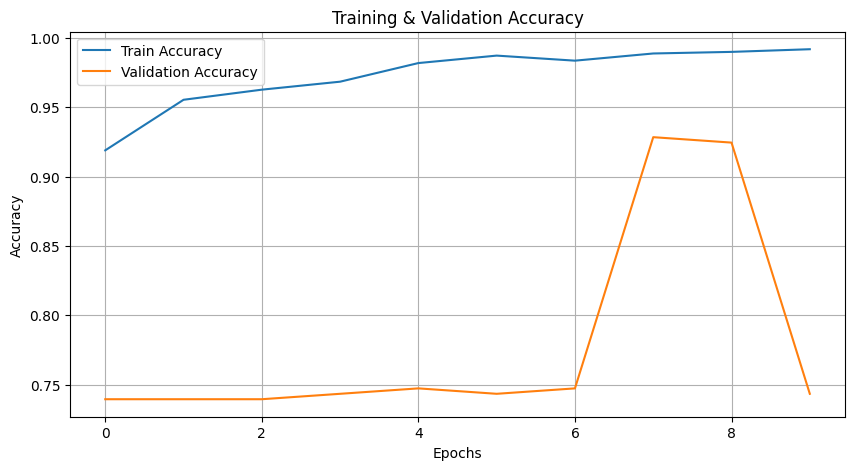

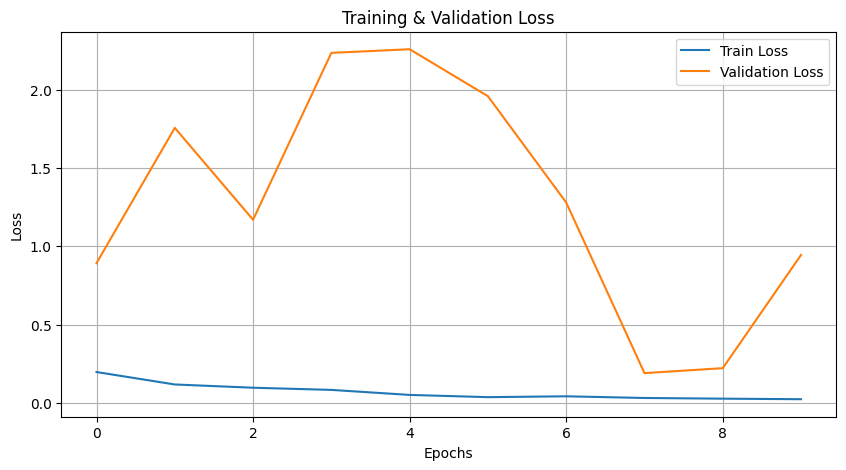

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 654ms/step


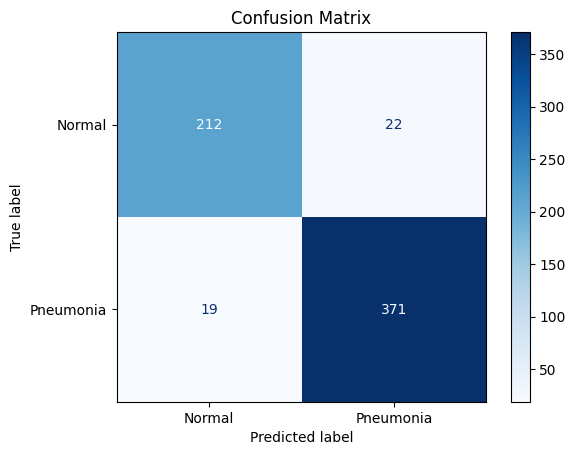

Precision: 0.9342, Recall: 0.9343, F1-Score: 0.9342


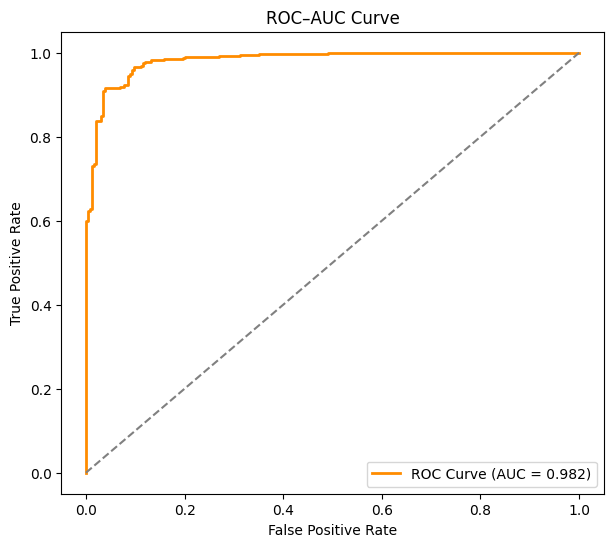

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step


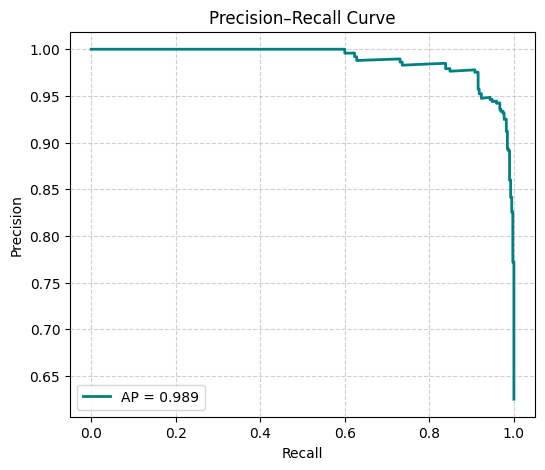

/tmp/ipython-input-4086379917.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


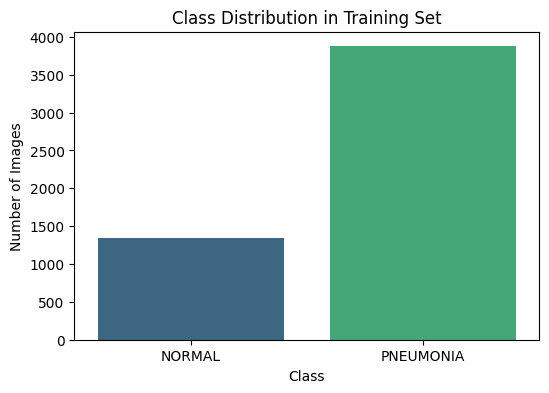

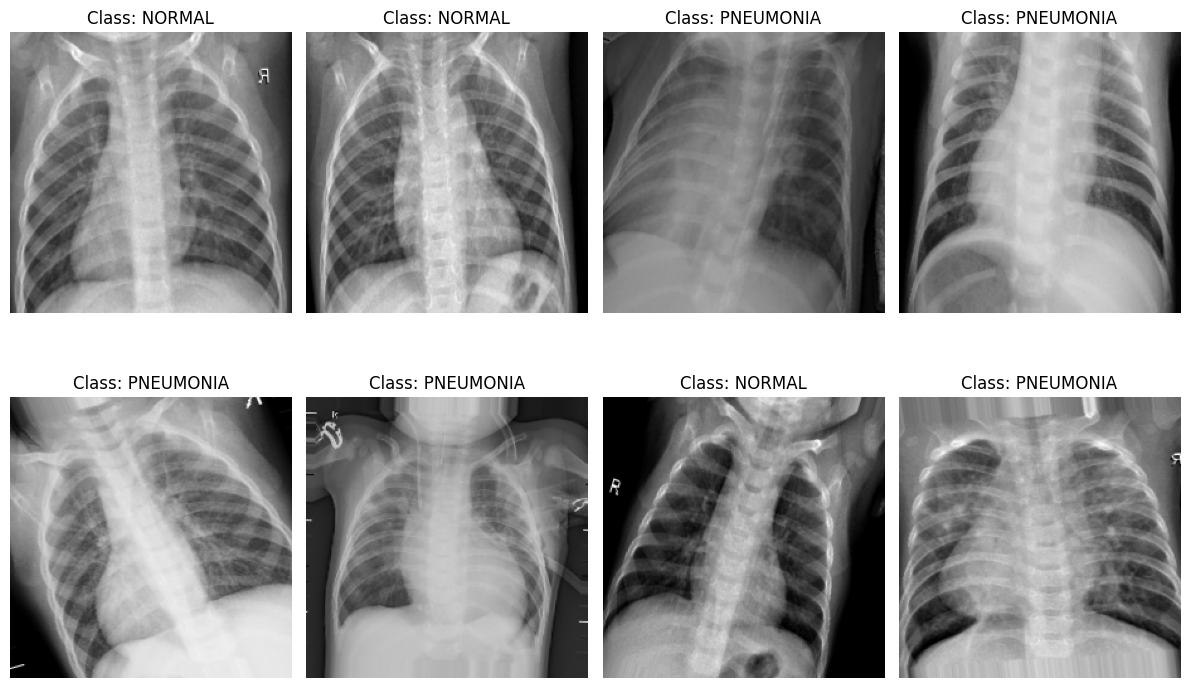

In [20]:
# ==============================================
# 5️⃣ EVALUATION, VISUALIZATION, AND RESULT SAVING
# ==============================================

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score # Import missing functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load best model for evaluation
best_model = load_model('/content/drive/MyDrive/Chest_Xray_Model/best_model.keras')

# Evaluate on validation and test sets
val_loss, val_acc = best_model.evaluate(val_gen)
test_loss, test_acc = best_model.evaluate(test_gen)

print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# =================================================
# Visualization - Accuracy and Loss Curves
# =================================================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# =================================================
# Confusion Matrix and Classification Report
# =================================================
y_true = test_gen.classes
y_pred = best_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia']) # Define disp here
disp.plot(cmap='Blues'); plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia'], output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# =================================================
# ROC–AUC Curve
# =================================================
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve')
plt.legend(); plt.show()

#Precision–Recall Curve
y_pred_proba = best_model.predict(test_gen).ravel()
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#Classification Report - already printed above, removing duplicate
#print(classification_report(y_true, y_pred_classes))

# Extract class indices and labels
labels = list(train_gen.class_indices.keys())

# Get the class names for each image in the training generator
class_names = [labels[i] for i in train_gen.classes]

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Class': class_names})

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#Dataset Visualization

# Get one batch of images and labels
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,8))
for i in range(8):  # display first 8 images
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])

    # Since class_mode='binary', y_batch[i] is 0 or 1
    class_label = list(train_gen.class_indices.keys())[int(y_batch[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# ==============================================
# 6️⃣ SAVE MODEL, PLOTS, AND METRICS TO CSV LOG
# ==============================================

import csv
import os
from datetime import datetime # Import datetime

# Create Result_Final directory
base_dir = '/content/drive/MyDrive/Chest_Xray_Model/Result_Final'
os.makedirs(base_dir, exist_ok=True)

# Create timestamped subfolder
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_folder = os.path.join(base_dir, f"run_{timestamp}")
os.makedirs(run_folder, exist_ok=True)

# Save model
model_path = os.path.join(run_folder, "efficientNetB0_model.keras")
best_model.save(model_path)

# Save accuracy/loss plots
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')
plt.savefig(os.path.join(run_folder, "accuracy_plot.png")); plt.close()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.savefig(os.path.join(run_folder, "loss_plot.png")); plt.close()

# Save confusion matrix
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig(os.path.join(run_folder, "confusion_matrix.png"))
plt.close()

# Save ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.legend(); plt.title('ROC–AUC Curve')
plt.savefig(os.path.join(run_folder, "roc_curve.png"))
plt.close()

# Write metrics to CSV
csv_file = os.path.join(base_dir, "final_results_log.csv")
fieldnames = [
    "Timestamp", "Epochs",
    "Train_Accuracy", "Val_Accuracy", "Val_Loss",
    "Best_Val_Accuracy", "Best_Val_Loss",
    "Test_Accuracy", "Test_Loss",
    "Precision", "Recall", "F1_Score", "ROC_AUC",
    "Run_Folder_Path"
]
# Get best metrics from training history
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

file_exists = os.path.isfile(csv_file)
with open(csv_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow({
        "Timestamp": timestamp,
        "Epochs": len(history.history['accuracy']),
        "Train_Accuracy": history.history['accuracy'][-1],
        "Val_Accuracy": val_acc,
        "Val_Loss": val_loss,
        "Best_Val_Accuracy": best_val_acc,
        "Best_Val_Loss": best_val_loss,
        "Test_Accuracy": test_acc,
        "Test_Loss": test_loss,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "ROC_AUC": roc_auc,
        "Run_Folder_Path": run_folder
    })

print(f"\n✅ Final results saved in: {run_folder}")
print(f"📊 Metrics logged in: {csv_file}")


✅ Final results saved in: /content/drive/MyDrive/Chest_Xray_Model/Result_Final/run_2025-10-12_06-26-11
📊 Metrics logged in: /content/drive/MyDrive/Chest_Xray_Model/Result_Final/final_results_log.csv


# Accuracy **measuring**

In [ ]:
# # Evaluate the trained model using the train_generator
# # print("\nEvaluating the model on the train set:")
# train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
# print(f"Train Loss: {train_loss:.4f}")
# print(f"Train Accuracy: {train_accuracy:.4f}")

In [ ]:
# # Evaluate the trained model using the test_generator
# print("\nEvaluating the model on the test set:")
# test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# # Evaluate the trained model using the val_generator
# print("\nEvaluating the model on the validation set:")
# val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
# # Plot training and validation accuracy and loss curves
# print("\nPlotting training and validation curves...")

# # Access the history object from the model training cell (cell 788c262d)
# # Ensure the history variable is accessible in this cell's scope

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
# plt.show()

# print("Training and validation curves plotted.")

## Save Results (Optional)

### Subtask:
Save any results, trained models, or processed data.

In [ ]:
# # Save the trained model (optional)
# # You can save the entire model in the Keras native format
# model_save_path = '/content/drive/My Drive/chest_xray_model.keras' # Or a path within your cloned repo if preferred
# try:
#     model.save(model_save_path)
#     print(f"Model saved successfully to {model_save_path}")
# except Exception as e:
#     print(f"Error saving model: {e}")

# # You might also want to save the training history
# # import json
# # history_save_path = '/content/drive/My Drive/chest_xray_history.json'
# # try:
# #     with open(history_save_path, 'w') as f:
# #         json.dump(history.history, f)
# #     print(f"Training history saved successfully to {history_save_path}")
# # except Exception as e:
# #     print(f"Error saving history: {e}")